In [ ]:
!pip3.6 install unidip

In [ ]:
#Opinion Dynamics, Polarization, Disagreement
import sys
import numpy as np
import networkx as nx
import math

# FJ dynamics with Z* = (L+I)^(-1)|s
# Getting rid of other variations as they dont make a lot of sense
# This implementation takes more time because of inverse calculation
def change_fj_opinions_naive(n, weighted_graph, innate_opinion):
    laplace = nx.linalg.normalized_laplacian_matrix(weighted_graph)
    identity = np.identity(n, dtype = float) 

    new_opinion = np.dot(np.linalg.inv(laplace + identity),innate_opinion)
    new_opinion = np.array(new_opinion).reshape(-1)
    return new_opinion

# This is a faster approach
def change_fj_opinions(n, weighted_graph, innate_opinion):
    laplace = nx.linalg.normalized_laplacian_matrix(weighted_graph)
    identity = np.identity(n, dtype = float) 

    new_opinion = np.linalg.solve(laplace + identity, innate_opinion)
    new_opinion = np.array(new_opinion).reshape(-1)
    return new_opinion

def calculate_polarization(opinions):
  return np.var(np.array(opinions))

def calculate_disagreement(G, opinions):
  laplace = nx.linalg.laplacian_matrix(G).toarray()
  opinions_exp = np.expand_dims(opinions, axis=0)
  inter_1 = np.dot(laplace, opinions_exp.T)
  inter_2 = np.dot(opinions_exp.squeeze(), inter_1.squeeze())
  return inter_2.squeeze()

def calculate_average_degree(G, n):
    # seq = np.arange(n)
    # deg_seq = G.degree(seq)
    # mean = sum(deg for _,deg in deg_seq)
    # return mean/n
    return G.number_of_edges()

In [ ]:
#Probabilistic Edge Removal

def remove_edges(G, new_opinion, n):
  #Forming a distribution of edges and removig n of them
  edges_list = list(G.edges)

  n_edges = len(edges_list)
  disr = []
  for e in edges_list:
    disr.append(abs(new_opinion[e[0]] - new_opinion[e[1]]))

  sum_value = sum(disr)
  disr = disr/sum_value

  if n < n_edges:
      to_remove = choice(np.arange(n_edges), n, replace=False, p=disr)
  else:
      to_remove = choice(np.arange(n_edges), n_edges//2, replace=False, p=disr)

  to_remove_edges = [edges_list[i] for i in to_remove]

  for ed in to_remove_edges:
    if G.degree(ed[0]) != 1 and  G.degree(ed[1]) != 1:
      G.remove_edge(ed[0], ed[1])
  
  return len(to_remove_edges)


#Probabilistic model to remove edges, sample edge from a distribution weighted by the difference in opinion
def remove_edges_with_less_weights(G, new_opinion, n):
  #Forming a distribution of edges and removig n of them
  edges_list = list(G.edges)

  n_edges = len(edges_list)
  disr = []
  for e in edges_list:
    disr.append(math.sqrt(abs(new_opinion[e[0]] - new_opinion[e[1]])))

  sum_value = sum(disr)
  for i,d in enumerate(disr):
    disr[i] = disr[i]/sum_value

  if n < n_edges:
      to_remove = choice(np.arange(n_edges), n, replace=False, p=disr)
  else:
      to_remove = choice(np.arange(n_edges), n_edges//2, replace=False, p=disr)

  to_remove_edges = [edges_list[i] for i in to_remove]

  for ed in to_remove_edges:
    if G.degree(ed[0]) != 1 and  G.degree(ed[1]) != 1:
      G.remove_edge(ed[0], ed[1])
  
  return len(to_remove_edges)

In [ ]:
#FOF Recommender
import random

def friends_set(G, node):
  return set(G.neighbors(node))

def friends_of_friends_set(G, friends):
  friends_of_friends = set()

  for f in friends:
    friends_of_friends.update(G.neighbors(f))
  
  return friends_of_friends

def make_remove_set(G, node, friends_of_friends):
    """Removes friends of friends that a user is already friends with"""
    remove_set = set()
    
    for fof in friends_of_friends:
        if G.has_edge(node, fof):
            remove_set.add(fof)
            
    return remove_set

def find_friends_of_friends(G, node):
  # Find the list of friends of friends who the user is not friends with

  friends = friends_set(G, node)
  friends_of_friends = friends_of_friends_set(G, friends)
  to_remove = make_remove_set(G, node, friends_of_friends)
  friends_of_friends.difference_update(to_remove)
  return friends_of_friends

def suggest_Friend(G, node, n):
  fof = find_friends_of_friends(G, node)

  if node in fof:
    fof.remove(node)

  if not fof:
    return None

  fof = list(fof)
  return fof[random.randint(0,len(fof) - 1)]

def add_new_friend_for_each_node(G,to_add,n):
  new_edges_to_add = set()
  while len(new_edges_to_add) < to_add:
    node = random.randint(0,n - 1)
    friend_to_Add = suggest_Friend(G,node,n)
    if friend_to_Add:
      new_edges_to_add.add((node,friend_to_Add))
  
  G.add_edges_from(list(new_edges_to_add))


In [ ]:
# Experiment Number 1: 
# To proove that number of nodes do not make a huge difference in polarization 
# as long as the number of nodes are very less, which is generally not true in 
# real social network graphs.

# Setup:
# Opinion Initial : [-1 to 1]
# Keeping the average degree constant by varying p and N - 20
# Experiement on two different constant degree values
# Simple edge removal and addition process
# Plot polarization, disagreement and modality


from tqdm import tqdm
import collections
import matplotlib.pyplot as plt 
from numpy.random import choice
import random
from unidip import UniDip

nodes = [50, 100, 250, 500]
polarizations = collections.defaultdict(list)
disagreements = collections.defaultdict(list)
modalities = collections.defaultdict(list)
iterations = 500
degree = 20
trials = 5

for o,n in tqdm(enumerate(nodes)):
    p = degree/n
    for q in tqdm(range(trials)):
        G = nx.generators.random_graphs.gnp_random_graph(n,p)
        innate_opinion = [random.uniform(-1,1) for _ in range(n)]
        average_degree = calculate_average_degree(G,n)

        polarization = []
        disagreement = []
        modality = []

        new_opinion = change_fj_opinions(n, G, innate_opinion)
        polarization.append(calculate_polarization(new_opinion))
        disagreement.append(calculate_disagreement(G,new_opinion)/average_degree)
        dat = np.msort(new_opinion)
        intervals = UniDip(dat).run()
        mod = len(intervals)
        modality.append(mod)

        for i in tqdm(range(iterations)):
            r = remove_edges(G, new_opinion, n//2)
            add_new_friend_for_each_node(G,r,n)
            average_degree = calculate_average_degree(G,n)
            new_opinion = change_fj_opinions(n, G, innate_opinion)
            dat = np.msort(new_opinion)
            intervals = UniDip(dat).run()
            mod = len(intervals)
            modality.append(mod)
            pol = calculate_polarization(new_opinion)
            polarization.append(pol)
            dis = calculate_disagreement(G,new_opinion)/average_degree
            disagreement.append(dis)
        
        polarizations[o].append(polarization)
        disagreements[o].append(disagreement)
        modalities[o].append(modality)


Polarization plot over time


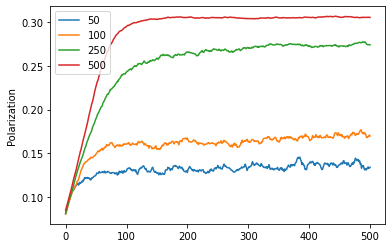

Plotting polarization versus nodes


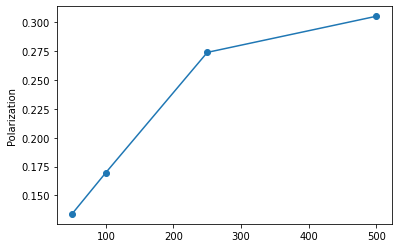

Disagreement plot over time


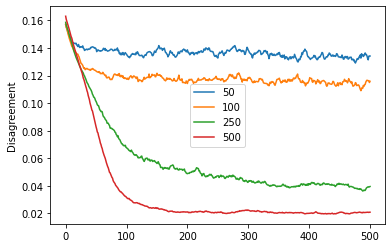

Plotting Disagreement versus nodes


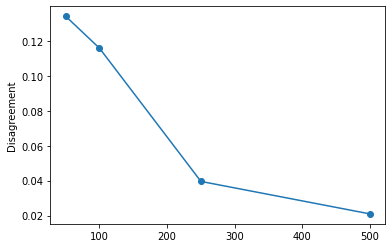

Modality plot over time


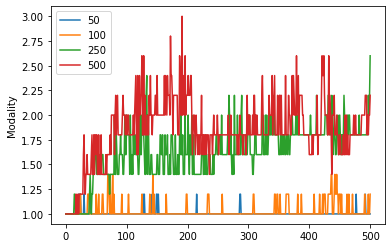

Plotting Modality versus nodes


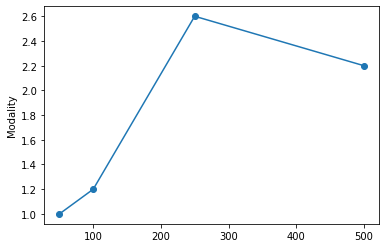

For Graph of size 50, polarization is:


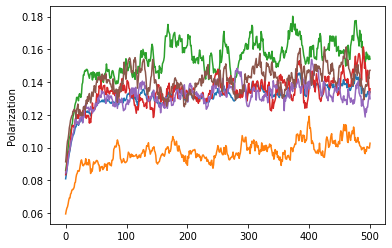

For Graph of size 100, polarization is:


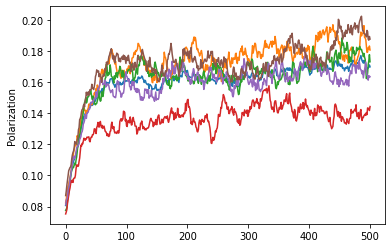

For Graph of size 250, polarization is:


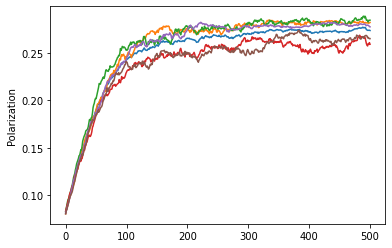

For Graph of size 500, polarization is:


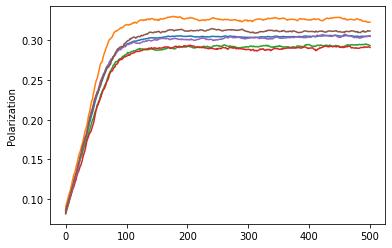

For Graph of size 50, disagreement is:


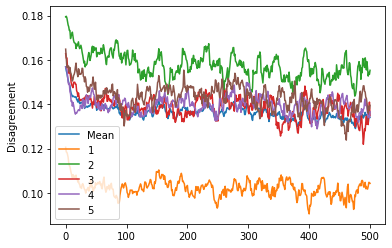

For Graph of size 100, disagreement is:


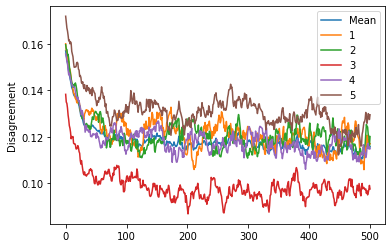

For Graph of size 250, disagreement is:


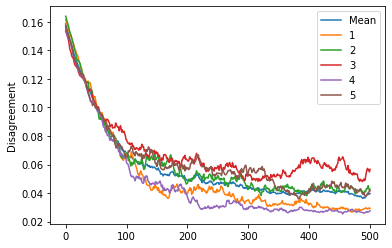

For Graph of size 500, disagreement is:


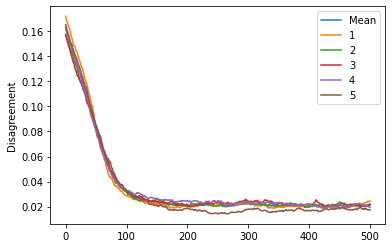

For Graph of size 50, modailty is:


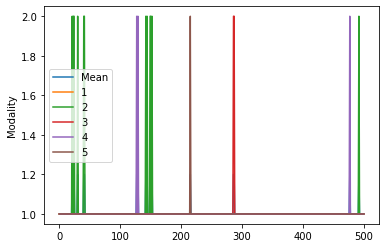

For Graph of size 100, modailty is:


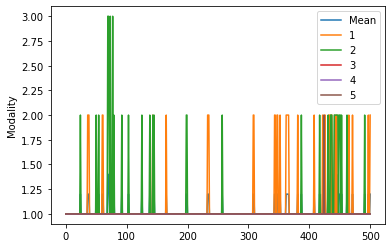

For Graph of size 250, modailty is:


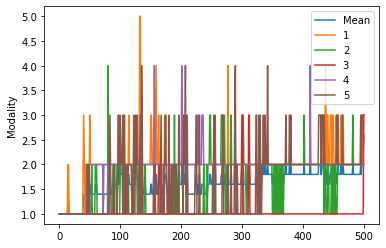

For Graph of size 500, modailty is:


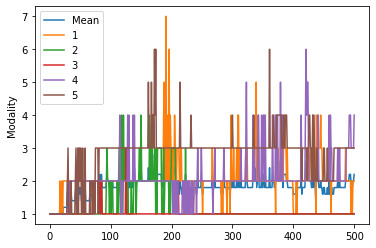

For Graph of size 50, average modailty is:


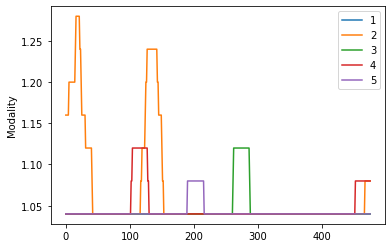

For Graph of size 100, average modailty is:


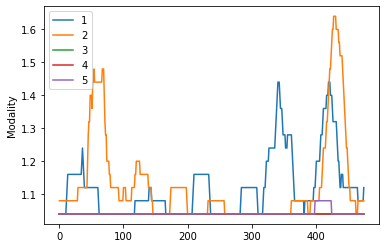

For Graph of size 250, average modailty is:


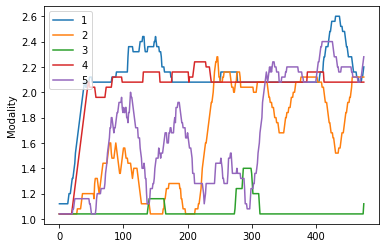

For Graph of size 500, average modailty is:


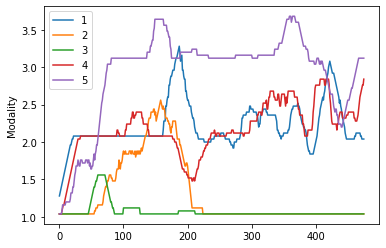

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from unidip import UniDip

final_polarizations = []
final_disagreements = []
final_modalities = []
length = len(nodes)
for i in range(length):
    final_polarizations.append(np.mean(np.array(polarizations[i]), axis = 0)) 
    final_disagreements.append(np.mean(np.array(disagreements[i]), axis = 0))
    final_modalities.append(np.mean(np.array(modalities[i]), axis = 0)) 

iterations_array = np.arange(iterations + 1)

print("Polarization plot over time")
for i in range(length):
    plt.plot(iterations_array, final_polarizations[i])
plt.legend(nodes)
plt.ylabel('Polarization')
plt.show()

print("Plotting polarization versus nodes")
final_p = []
for i in range(length):
  final_p.append(final_polarizations[i][-1])
plt.plot(nodes, final_p, marker='o')
plt.ylabel('Polarization')
plt.show()


print("Disagreement plot over time")
for i in range(length):
    plt.plot(iterations_array, final_disagreements[i])
plt.legend(nodes)
plt.ylabel('Disagreement')
plt.show()

print("Plotting Disagreement versus nodes")
final_d = []
for i in range(length):
  final_d.append(final_disagreements[i][-1])
plt.plot(nodes, final_d, marker='o')
plt.ylabel('Disagreement')
plt.show()

print("Modality plot over time")
for i in range(length):
    plt.plot(iterations_array, final_modalities[i])
plt.legend(nodes)
plt.ylabel('Modality')
plt.show()

print("Plotting Modality versus nodes")
final_m = []
for i in range(length):
  final_m.append(final_modalities[i][-1])
plt.plot(nodes, final_m, marker='o')
plt.ylabel('Modality')
plt.show()

#Creating the legend
legend_array_with_mean = ["Mean"]
legend_array_without_mean = []
for k in range(trials):
  legend_array_with_mean.append(str(k+1))
  legend_array_without_mean.append(str(k+1))

for i,n in enumerate(nodes):
    print("For Graph of size %d, polarization is:" %n)
    plt.plot(iterations_array, final_polarizations[i])
    for j in range(trials):
        plt.plot(iterations_array, polarizations[i][j])
    plt.ylabel('Polarization')
    plt.show()

for i,n in enumerate(nodes):
    print("For Graph of size %d, disagreement is:" %n)
    plt.plot(iterations_array, final_disagreements[i])
    for j in range(trials):
        plt.plot(iterations_array, disagreements[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Disagreement')
    plt.show()


for i,n in enumerate(nodes):
    print("For Graph of size %d, modailty is:" %n)
    plt.plot(iterations_array, final_modalities[i])
    for j in range(trials):
        plt.plot(iterations_array, modalities[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Modality')
    plt.show()

average_number = 25
for i,n in enumerate(nodes):
    print("For Graph of size %d, average modailty is:" %n)
    for j in range(5):
      modality = modalities[i][j]
      average_sum = np.sum(np.array(modality)[:average_number+1])/average_number
      altered_modality = [average_sum]
      for k in range(1, iterations - average_number + 1):
        sum_value = average_sum*average_number - modality[k-1] + modality[k + average_number]
        average_sum = sum_value/average_number
        altered_modality.append(average_sum)
      altered_iterations_array = np.arange(iterations - average_number + 1)
      plt.plot(altered_iterations_array, altered_modality)
    plt.legend(legend_array_without_mean)
    plt.ylabel('Modality')
    plt.show()

In [ ]:
# Experiment Number 2: 
# To proove that number of nodes do not make a huge difference in polarization 
# as long as the number of nodes are very less, which is generally not true in 
# real social network graphs.

# Setup:
# Opinion Initial : [-1 to 1]
# Keeping the average degree constant by varying p and N as 50
# Experiement on two different constant degree values
# Simple edge removal and addition process
# Plot polarization, disagreement and modality


from tqdm import tqdm
import collections
import matplotlib.pyplot as plt 
from numpy.random import choice
import random
from unidip import UniDip

nodes = [50, 100, 250, 500]
polarizations = collections.defaultdict(list)
disagreements = collections.defaultdict(list)
modalities = collections.defaultdict(list)
iterations = 500
degree = 50
trials = 5

for o,n in tqdm(enumerate(nodes)):
    p = degree/n
    for q in tqdm(range(trials)):
        G = nx.generators.random_graphs.gnp_random_graph(n,p)
        innate_opinion = [random.uniform(-1,1) for _ in range(n)]
        average_degree = calculate_average_degree(G,n)

        polarization = []
        disagreement = []
        modality = []

        new_opinion = change_fj_opinions(n, G, innate_opinion)
        polarization.append(calculate_polarization(new_opinion))
        disagreement.append(calculate_disagreement(G,new_opinion)/average_degree)
        dat = np.msort(new_opinion)
        intervals = UniDip(dat).run()
        mod = len(intervals)
        modality.append(mod)

        for i in tqdm(range(iterations)):
            r = remove_edges(G, new_opinion, n//2)
            add_new_friend_for_each_node(G,r,n)
            average_degree = calculate_average_degree(G,n)
            new_opinion = change_fj_opinions(n, G, innate_opinion)
            dat = np.msort(new_opinion)
            intervals = UniDip(dat).run()
            mod = len(intervals)
            modality.append(mod)
            pol = calculate_polarization(new_opinion)
            polarization.append(pol)
            dis = calculate_disagreement(G,new_opinion)/average_degree
            disagreement.append(dis)
        
        polarizations[o].append(polarization)
        disagreements[o].append(disagreement)
        modalities[o].append(modality)


Polarization plot over time


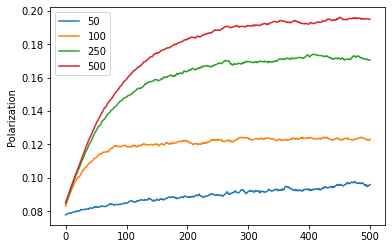

Plotting polarization versus nodes


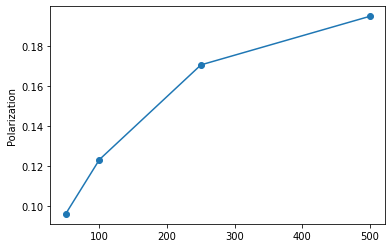

Disagreement plot over time


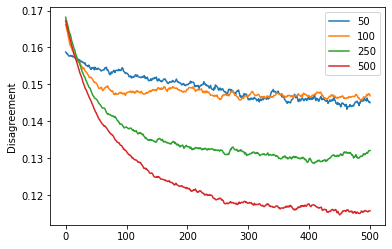

Plotting Disagreement versus nodes


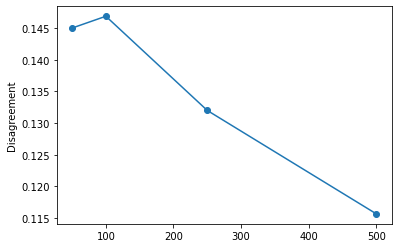

Modality plot over time


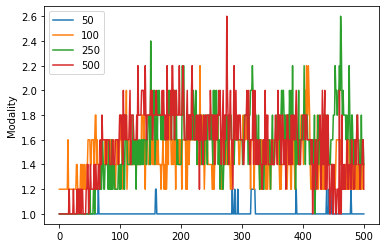

Plotting Modality versus nodes


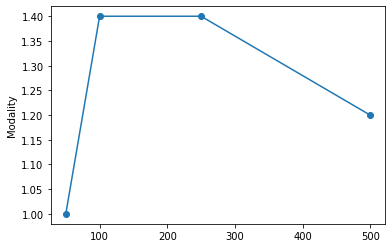

For Graph of size 50, polarization is:


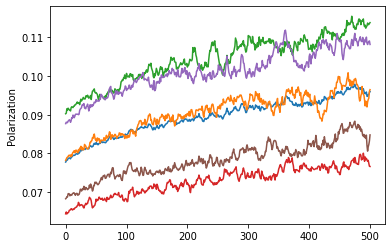

For Graph of size 100, polarization is:


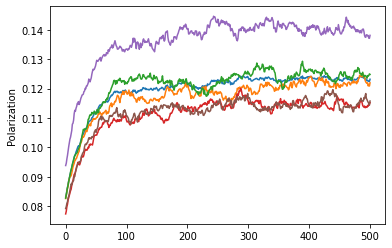

For Graph of size 250, polarization is:


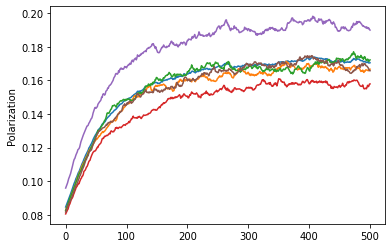

For Graph of size 500, polarization is:


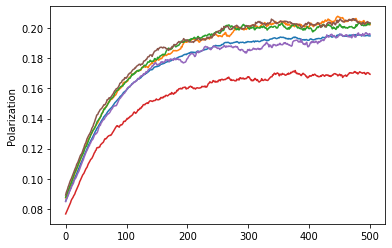

For Graph of size 50, disagreement is:


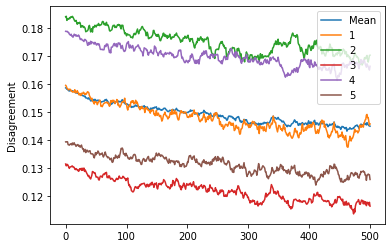

For Graph of size 100, disagreement is:


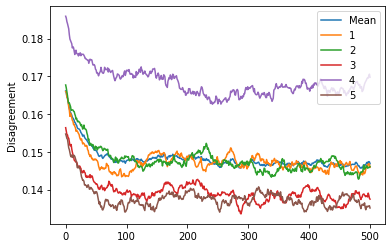

For Graph of size 250, disagreement is:


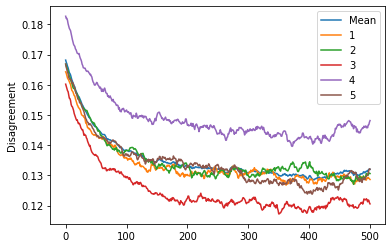

For Graph of size 500, disagreement is:


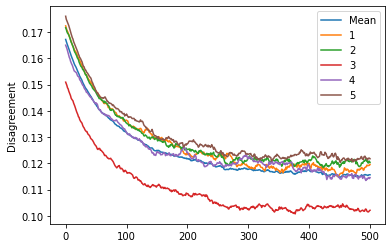

For Graph of size 50, modailty is:


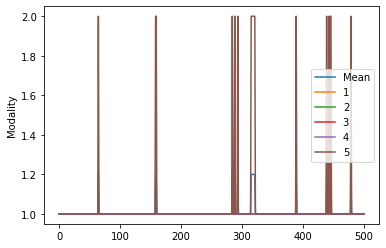

For Graph of size 100, modailty is:


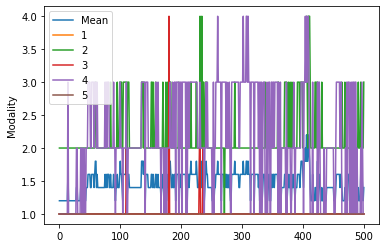

For Graph of size 250, modailty is:


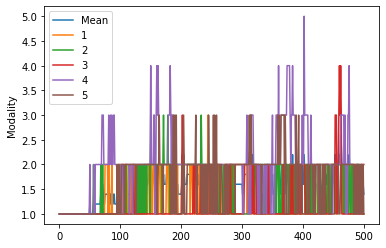

For Graph of size 500, modailty is:


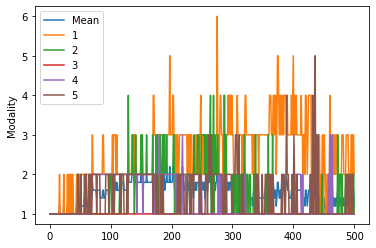

For Graph of size 50, average modailty is:


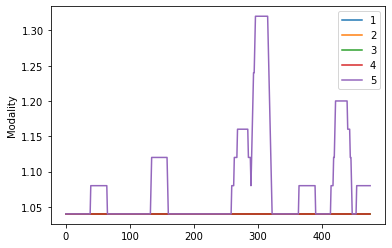

For Graph of size 100, average modailty is:


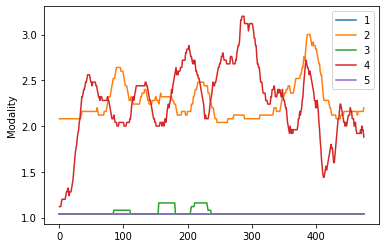

For Graph of size 250, average modailty is:


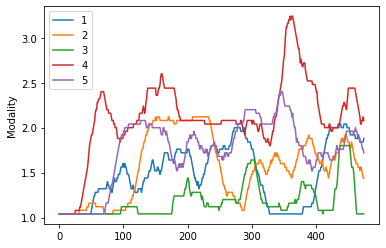

For Graph of size 500, average modailty is:


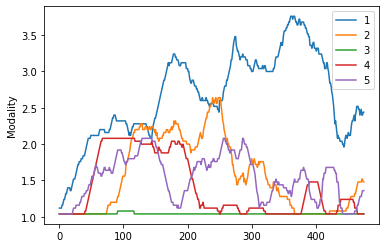

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from unidip import UniDip

final_polarizations = []
final_disagreements = []
final_modalities = []
length = len(nodes)
for i in range(length):
    final_polarizations.append(np.mean(np.array(polarizations[i]), axis = 0)) 
    final_disagreements.append(np.mean(np.array(disagreements[i]), axis = 0))
    final_modalities.append(np.mean(np.array(modalities[i]), axis = 0)) 

iterations_array = np.arange(iterations + 1)

print("Polarization plot over time")
for i in range(length):
    plt.plot(iterations_array, final_polarizations[i])
plt.legend(nodes)
plt.ylabel('Polarization')
plt.show()

print("Plotting polarization versus nodes")
final_p = []
for i in range(length):
  final_p.append(final_polarizations[i][-1])
plt.plot(nodes, final_p, marker='o')
plt.ylabel('Polarization')
plt.show()


print("Disagreement plot over time")
for i in range(length):
    plt.plot(iterations_array, final_disagreements[i])
plt.legend(nodes)
plt.ylabel('Disagreement')
plt.show()

print("Plotting Disagreement versus nodes")
final_d = []
for i in range(length):
  final_d.append(final_disagreements[i][-1])
plt.plot(nodes, final_d, marker='o')
plt.ylabel('Disagreement')
plt.show()

print("Modality plot over time")
for i in range(length):
    plt.plot(iterations_array, final_modalities[i])
plt.legend(nodes)
plt.ylabel('Modality')
plt.show()

print("Plotting Modality versus nodes")
final_m = []
for i in range(length):
  final_m.append(final_modalities[i][-1])
plt.plot(nodes, final_m, marker='o')
plt.ylabel('Modality')
plt.show()

#Creating the legend
legend_array_with_mean = ["Mean"]
legend_array_without_mean = []
for k in range(trials):
  legend_array_with_mean.append(str(k+1))
  legend_array_without_mean.append(str(k+1))

for i,n in enumerate(nodes):
    print("For Graph of size %d, polarization is:" %n)
    plt.plot(iterations_array, final_polarizations[i])
    for j in range(trials):
        plt.plot(iterations_array, polarizations[i][j])
    plt.ylabel('Polarization')
    plt.show()

for i,n in enumerate(nodes):
    print("For Graph of size %d, disagreement is:" %n)
    plt.plot(iterations_array, final_disagreements[i])
    for j in range(trials):
        plt.plot(iterations_array, disagreements[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Disagreement')
    plt.show()


for i,n in enumerate(nodes):
    print("For Graph of size %d, modailty is:" %n)
    plt.plot(iterations_array, final_modalities[i])
    for j in range(trials):
        plt.plot(iterations_array, modalities[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Modality')
    plt.show()

average_number = 25
for i,n in enumerate(nodes):
    print("For Graph of size %d, average modailty is:" %n)
    for j in range(5):
      modality = modalities[i][j]
      average_sum = np.sum(np.array(modality)[:average_number+1])/average_number
      altered_modality = [average_sum]
      for k in range(1, iterations - average_number + 1):
        sum_value = average_sum*average_number - modality[k-1] + modality[k + average_number]
        average_sum = sum_value/average_number
        altered_modality.append(average_sum)
      altered_iterations_array = np.arange(iterations - average_number + 1)
      plt.plot(altered_iterations_array, altered_modality)
    plt.legend(legend_array_without_mean)
    plt.ylabel('Modality')
    plt.show()

In [ ]:
# Experiment Number 3: 
# To proove that connection probability do  make a huge difference in polarization 

# Setup:
# Opinion Initial : [-1 to 1]
# Simple edge removal and addition process
# Plot polarization, disagreement and modality

import matplotlib.pyplot as plt 
from numpy.random import choice
import random
import collections
from tqdm import tqdm
n = 500
iterations = 300
innate_opinion = [random.uniform(-1,1) for _ in range(n)]

connection_probs = [0.05, 0.1, 0.15, 0.2, 0.25,0.5]
trials = 5
polarizations = collections.defaultdict(list)
disagreements = collections.defaultdict(list)
modalities = collections.defaultdict(list)

for o,p in tqdm(enumerate(connection_probs)):
    for q in tqdm(range(trials)):
        G = nx.generators.random_graphs.gnp_random_graph(n,p)
        A = nx.linalg.graphmatrix.adjacency_matrix(G)

        average_degree = calculate_average_degree(G,n)

        polarization = []
        disagreement = []
        modality = []

        # Apply FJ opinion model to get the first equilibrium state
        new_opinion = change_fj_opinions(n, G, innate_opinion)
        polarization.append(calculate_polarization(new_opinion))
        disagreement.append(calculate_disagreement(G,new_opinion)/average_degree)
        dat = np.msort(new_opinion)
        intervals = UniDip(dat).run()
        mod = len(intervals)
        modality.append(mod)

        for i in tqdm(range(iterations)):
            r = remove_edges(G, new_opinion, n//2)
            add_new_friend_for_each_node(G,r,n)
            average_degree = calculate_average_degree(G,n)
            new_opinion = change_fj_opinions(n, G, innate_opinion)
            dat = np.msort(new_opinion)
            intervals = UniDip(dat).run()
            mod = len(intervals)
            modality.append(mod)
            pol = calculate_polarization(new_opinion)
            polarization.append(pol)
            dis = calculate_disagreement(G,new_opinion)/average_degree
            disagreement.append(dis)
        polarizations[o].append(polarization)
        disagreements[o].append(disagreement)
        modalities[o].append(modality)



Polarization plot over time


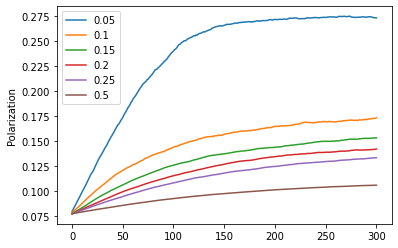

Plotting polarization versus Connection probs


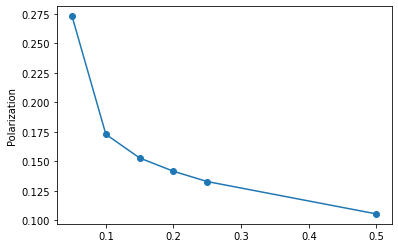

Disagreement plot over time


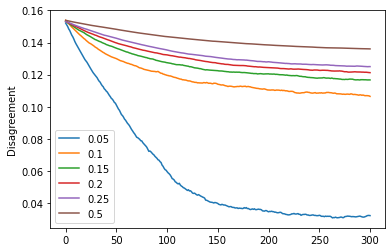

Plotting disagreement versus Connection probs


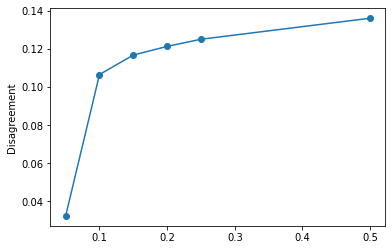

Modality plot over time


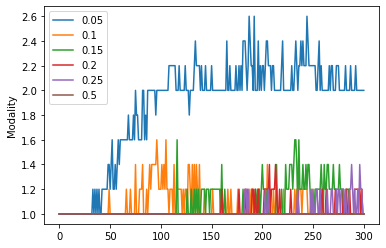

Plotting Modality versus Connection probs


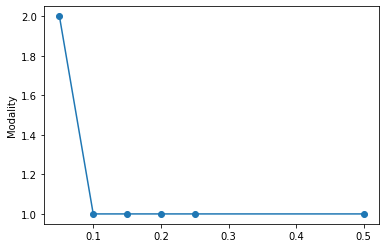

For Graph with prob 0.050000, polarization is:


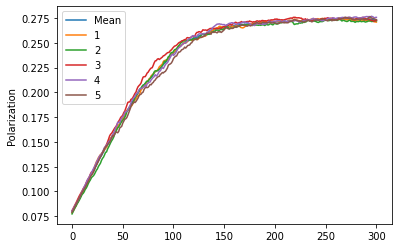

For Graph with prob 0.100000, polarization is:


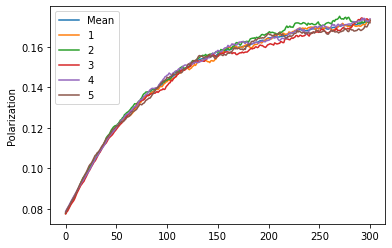

For Graph with prob 0.150000, polarization is:


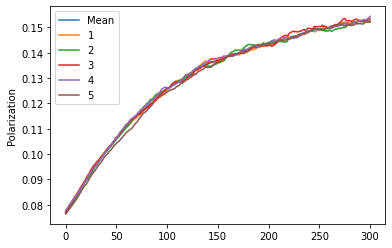

For Graph with prob 0.200000, polarization is:


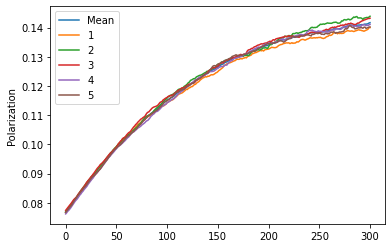

For Graph with prob 0.250000, polarization is:


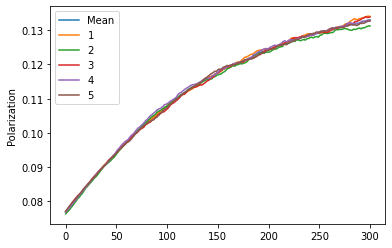

For Graph with prob 0.500000, polarization is:


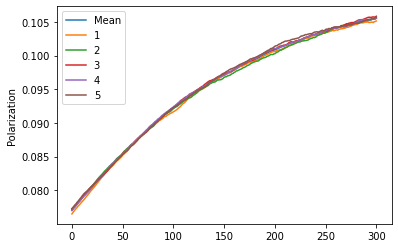

For Graph with prob 0.050000, disagreement is:


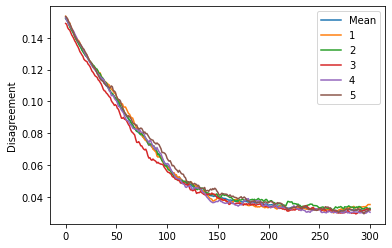

For Graph with prob 0.100000, disagreement is:


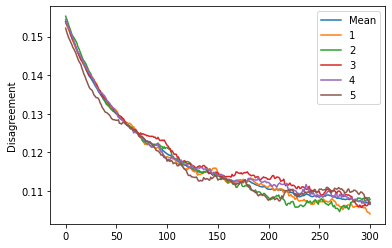

For Graph with prob 0.150000, disagreement is:


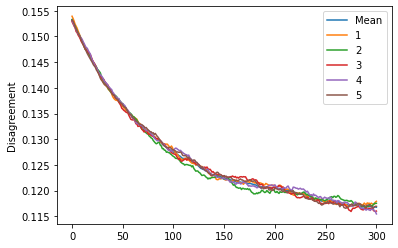

For Graph with prob 0.200000, disagreement is:


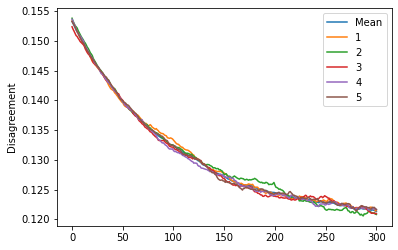

For Graph with prob 0.250000, disagreement is:


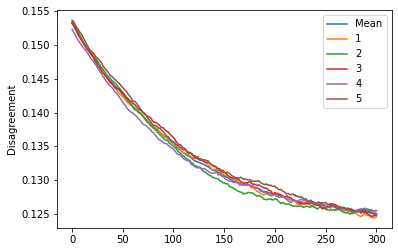

For Graph with prob 0.500000, disagreement is:


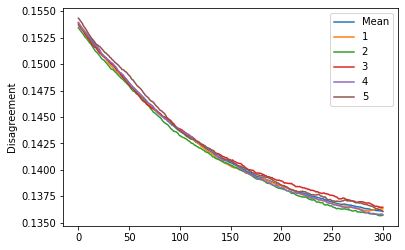

For Graph with prob 0.050000, modality is:


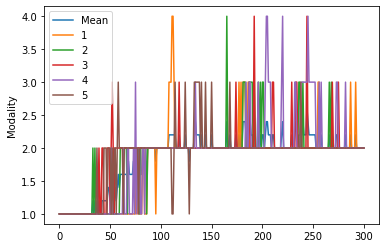

For Graph with prob 0.100000, modality is:


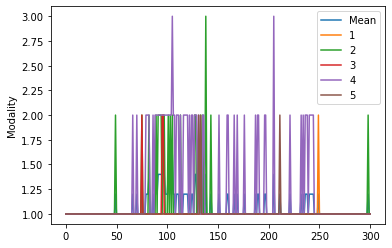

For Graph with prob 0.150000, modality is:


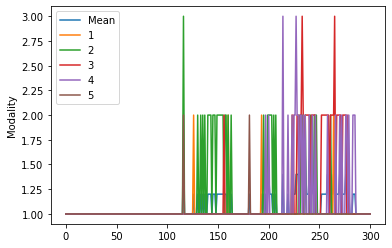

For Graph with prob 0.200000, modality is:


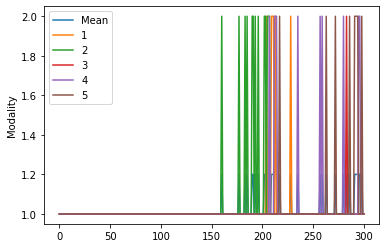

For Graph with prob 0.250000, modality is:


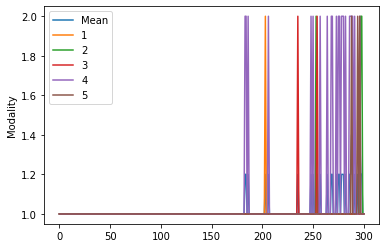

For Graph with prob 0.500000, modality is:


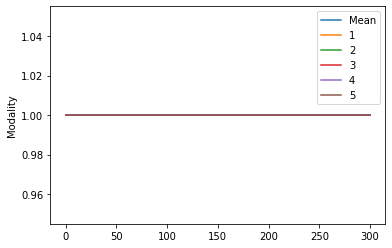

For Graph of size 50, average modailty is:


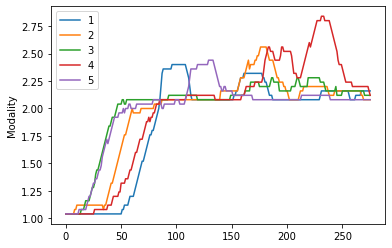

For Graph of size 100, average modailty is:


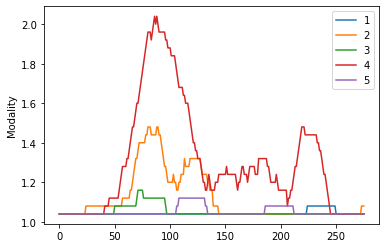

For Graph of size 250, average modailty is:


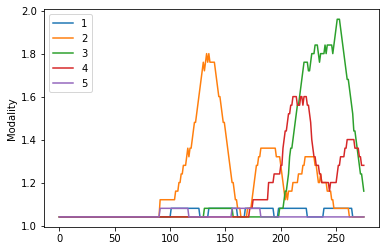

For Graph of size 500, average modailty is:


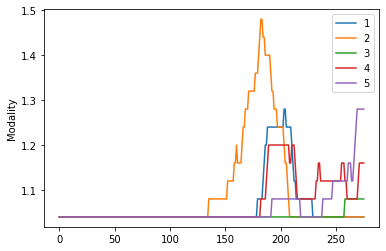

In [ ]:
import matplotlib.pyplot as plt

final_polarizations = []
final_disagreements = []
final_modalities = []
length = len(connection_probs)
for i in range(length):
    final_polarizations.append(np.mean(np.array(polarizations[i]), axis = 0)) 
    final_disagreements.append(np.mean(np.array(disagreements[i]), axis = 0)) 
    final_modalities.append(np.mean(np.array(modalities[i]), axis = 0)) 

iterations_array = np.arange(iterations + 1)

print("Polarization plot over time")
for i in range(length):
    plt.plot(iterations_array, final_polarizations[i])
plt.legend(connection_probs)
plt.ylabel('Polarization')
plt.show()

print("Plotting polarization versus Connection probs")
final_p = []
for i in range(length):
  final_p.append(final_polarizations[i][-1])
plt.plot(connection_probs, final_p, marker='o')
plt.ylabel('Polarization')
plt.show()

print("Disagreement plot over time")
for i in range(length):
    plt.plot(iterations_array, final_disagreements[i])
plt.legend(connection_probs)
plt.ylabel('Disagreement')
plt.show()

print("Plotting disagreement versus Connection probs")
final_d = []
for i in range(length):
  final_d.append(final_disagreements[i][-1])
plt.plot(connection_probs, final_d, marker='o')
plt.ylabel('Disagreement')
plt.show()

print("Modality plot over time")
for i in range(length):
    plt.plot(iterations_array, final_modalities[i])
plt.legend(connection_probs)
plt.ylabel('Modality')
plt.show()

print("Plotting Modality versus Connection probs")
final_m = []
for i in range(length):
  final_m.append(final_modalities[i][-1])
plt.plot(connection_probs, final_m, marker='o')
plt.ylabel('Modality')
plt.show()

#Creating the legend
legend_array_with_mean = ["Mean"]
legend_array_without_mean = []
for k in range(trials):
  legend_array_with_mean.append(str(k+1))
  legend_array_without_mean.append(str(k+1))

for i,p in enumerate(connection_probs):
    print("For Graph with prob %f, polarization is:" %p)
    plt.plot(iterations_array, final_polarizations[i])
    for j in range(trials):
        plt.plot(iterations_array, polarizations[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Polarization')
    plt.show()

for i,p in enumerate(connection_probs):
    print("For Graph with prob %f, disagreement is:" %p)
    plt.plot(iterations_array, final_disagreements[i])
    for j in range(trials):
        plt.plot(iterations_array, disagreements[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Disagreement')
    plt.show()

for i,p in enumerate(connection_probs):
    print("For Graph with prob %f, modality is:" %p)
    plt.plot(iterations_array, final_modalities[i])
    for j in range(trials):
        plt.plot(iterations_array, modalities[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Modality')
    plt.show()

average_number = 25
for i,n in enumerate(nodes):
    print("For Graph of size %d, average modailty is:" %n)
    for j in range(5):
      modality = modalities[i][j]
      average_sum = np.sum(np.array(modality)[:average_number+1])/average_number
      altered_modality = [average_sum]
      for k in range(1, iterations - average_number + 1):
        sum_value = average_sum*average_number - modality[k-1] + modality[k + average_number]
        average_sum = sum_value/average_number
        altered_modality.append(average_sum)
      altered_iterations_array = np.arange(iterations - average_number + 1)
      plt.plot(altered_iterations_array, altered_modality)
    plt.legend(legend_array_without_mean)
    plt.ylabel('Modality')
    plt.show()


In [ ]:
# Experiment Number 4: 
# To show how varying number of edge removal make a difference in polarization 

# Setup:
# Opinion Initial : [-1 to 1]
# Simple edge removal and addition process
# Plot polarization, disagreement and modality
import matplotlib.pyplot as plt 
from numpy.random import choice
import random
import collections
from tqdm import tqdm

n = 500
iterations = 300
innate_opinion = [random.uniform(-1,1) for _ in range(n)]
p = 0.15
removal_edges = [50, 100, 150, 200, 250]
polarizations = collections.defaultdict(list)
disagreements = collections.defaultdict(list)
modalities = collections.defaultdict(list)

for o,rem in tqdm(enumerate(removal_edges)):
    for q in tqdm(range(5)):   
        G = nx.generators.random_graphs.gnp_random_graph(n,p)
        A = nx.linalg.graphmatrix.adjacency_matrix(G)

        average_degree = calculate_average_degree(G,n)

        polarization = []
        disagreement = []
        modality = []
        # Apply FJ opinion model to get the first equilibrium state
        new_opinion = change_fj_opinions(n, G, innate_opinion)
        polarization.append(calculate_polarization(new_opinion))
        disagreement.append(calculate_disagreement(G,new_opinion)/average_degree)
        dat = np.msort(new_opinion)
        intervals = UniDip(dat).run()
        mod = len(intervals)
        modality.append(mod)

        for i in tqdm(range(iterations)):
            r = remove_edges(G, new_opinion, rem)
            add_new_friend_for_each_node(G,r,n)
            average_degree = calculate_average_degree(G,n)
            new_opinion = change_fj_opinions(n, G, innate_opinion)
            dat = np.msort(new_opinion)
            intervals = UniDip(dat).run()
            mod = len(intervals)
            modality.append(mod)
            pol = calculate_polarization(new_opinion)
            polarization.append(pol)
            dis = calculate_disagreement(G,new_opinion)/average_degree
            disagreement.append(dis)
        polarizations[o].append(polarization)
        disagreements[o].append(disagreement)
        modalities[o].append(modality)

Polarization plot over time


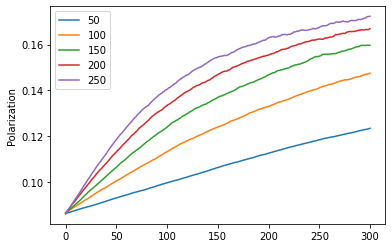

Plotting polarization versus Edge Removal


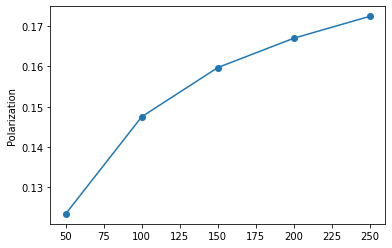

Disagreement plot over time


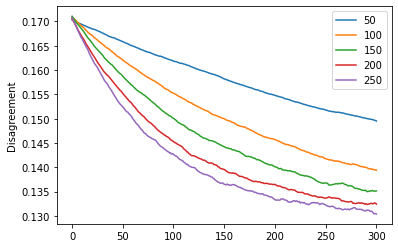

Plotting disagreement versus Edge Removal


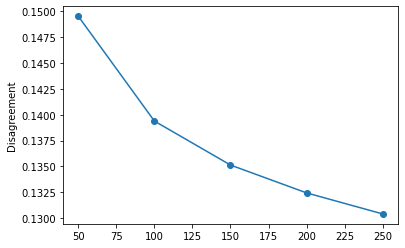

Modality plot over time


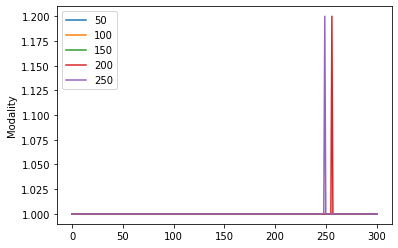

Plotting Modality versus Edge Removal


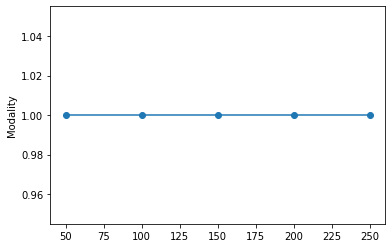

For removal of size 50, polarization is:


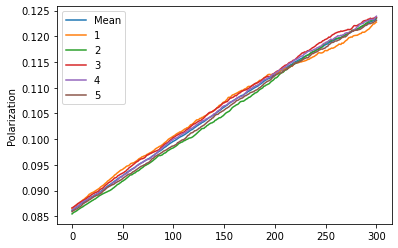

For removal of size 100, polarization is:


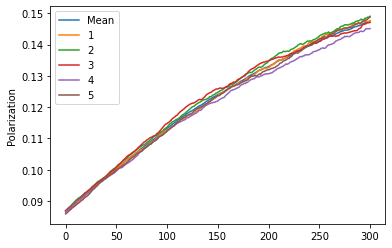

For removal of size 150, polarization is:


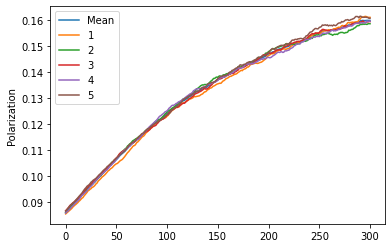

For removal of size 200, polarization is:


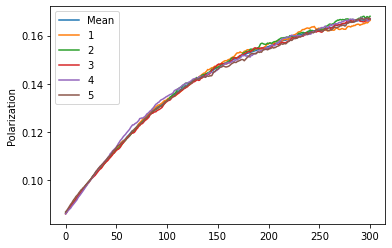

For removal of size 250, polarization is:


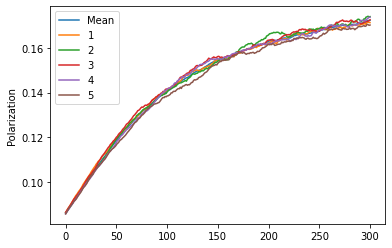

For removal of size 50, disagreement is:


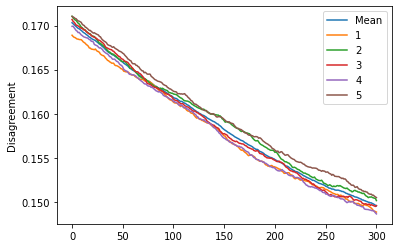

For removal of size 100, disagreement is:


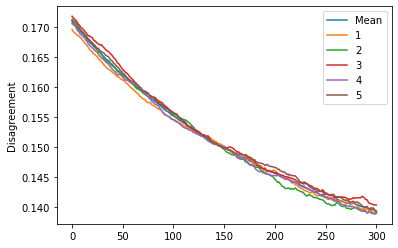

For removal of size 150, disagreement is:


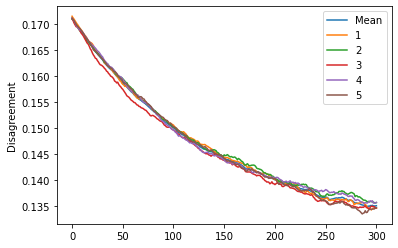

For removal of size 200, disagreement is:


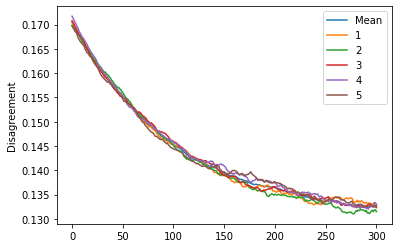

For removal of size 250, disagreement is:


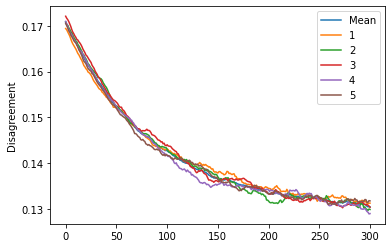

For removal of size 50, modality is:


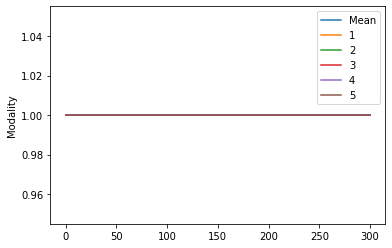

For removal of size 100, modality is:


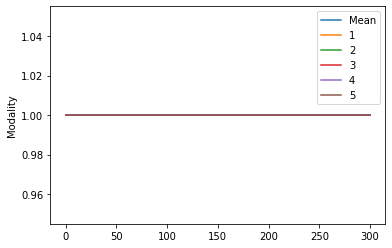

For removal of size 150, modality is:


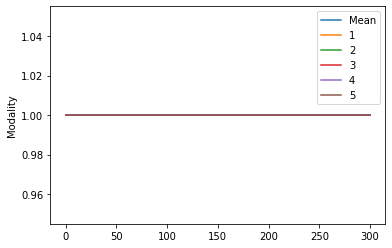

For removal of size 200, modality is:


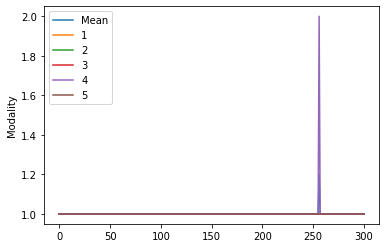

For removal of size 250, modality is:


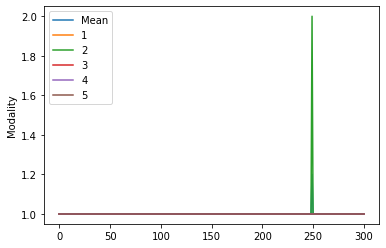

For Graph of size 50, average modailty is:


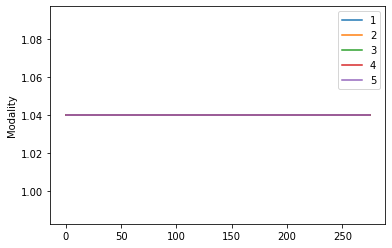

For Graph of size 100, average modailty is:


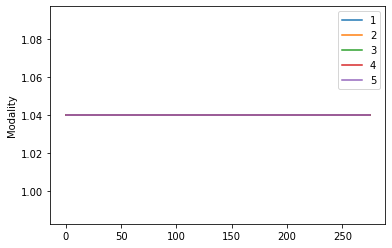

For Graph of size 250, average modailty is:


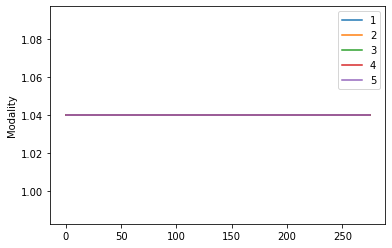

For Graph of size 500, average modailty is:


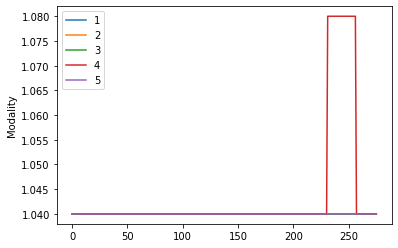

In [ ]:
import matplotlib.pyplot as plt

final_polarizations = []
final_disagreements = []
final_modalities = []
length = len(removal_edges)
for i in range(length):
    final_polarizations.append(np.mean(np.array(polarizations[i]), axis = 0)) 
    final_disagreements.append(np.mean(np.array(disagreements[i]), axis = 0)) 
    final_modalities.append(np.mean(np.array(modalities[i]), axis = 0)) 

iterations_array = np.arange(iterations + 1)

print("Polarization plot over time")
for i in range(length):
    plt.plot(iterations_array, final_polarizations[i])
plt.legend(removal_edges)
plt.ylabel('Polarization')
plt.show()

print("Plotting polarization versus Edge Removal")
final_p = []
for i in range(length):
  final_p.append(final_polarizations[i][-1])
plt.plot(removal_edges, final_p, marker='o')
plt.ylabel('Polarization')
plt.show()

print("Disagreement plot over time")
for i in range(length):
    plt.plot(iterations_array, final_disagreements[i])
plt.legend(removal_edges)
plt.ylabel('Disagreement')
plt.show()

print("Plotting disagreement versus Edge Removal")
final_d = []
for i in range(length):
  final_d.append(final_disagreements[i][-1])
plt.plot(removal_edges, final_d, marker='o')
plt.ylabel('Disagreement')
plt.show()

print("Modality plot over time")
for i in range(length):
    plt.plot(iterations_array, final_modalities[i])
plt.legend(removal_edges)
plt.ylabel('Modality')
plt.show()

print("Plotting Modality versus Edge Removal")
final_m = []
for i in range(length):
  final_m.append(final_modalities[i][-1])
plt.plot(removal_edges, final_m, marker='o')
plt.ylabel('Modality')
plt.show()

#Creating the legend
legend_array_with_mean = ["Mean"]
legend_array_without_mean = []
for k in range(trials):
  legend_array_with_mean.append(str(k+1))
  legend_array_without_mean.append(str(k+1))


for i,n in enumerate(removal_edges):
    print("For removal of size %d, polarization is:" %n)
    plt.plot(iterations_array, final_polarizations[i])
    for j in range(trials):
        plt.plot(iterations_array, polarizations[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Polarization')
    plt.show()

for i,n in enumerate(removal_edges):
    print("For removal of size %d, disagreement is:" %n)
    plt.plot(iterations_array, final_disagreements[i])
    for j in range(trials):
        plt.plot(iterations_array, disagreements[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Disagreement')
    plt.show()

for i,n in enumerate(removal_edges):
    print("For removal of size %d, modality is:" %n)
    plt.plot(iterations_array, final_modalities[i])
    for j in range(trials):
        plt.plot(iterations_array, modalities[i][j])
    plt.legend(legend_array_with_mean)
    plt.ylabel('Modality')
    plt.show()

average_number = 25
for i,n in enumerate(nodes):
    print("For Graph of size %d, average modailty is:" %n)
    for j in range(5):
      modality = modalities[i][j]
      average_sum = np.sum(np.array(modality)[:average_number+1])/average_number
      altered_modality = [average_sum]
      for k in range(1, iterations - average_number + 1):
        sum_value = average_sum*average_number - modality[k-1] + modality[k + average_number]
        average_sum = sum_value/average_number
        altered_modality.append(average_sum)
      altered_iterations_array = np.arange(iterations - average_number + 1)
      plt.plot(altered_iterations_array, altered_modality)
    plt.legend(legend_array_without_mean)
    plt.ylabel('Modality')
    plt.show()